In [1]:
import numpy as np 
import matplotlib.pyplot as plt
pi = np.pi
import copy
import scipy.linalg as scilinalg
from tqdm.notebook import tqdm
from scipy.integrate import quad
from numba import jit
import timeit
I = 1j

In [2]:
def round_matrix(mat): #function which rounds any matrix element with abs value <1e-12 to zero
    mat_rounded = copy.deepcopy(mat)
    for i in range(len(mat_rounded)):
        for j in range(len(mat_rounded[i])):
            if np.abs(np.real(mat_rounded[i,j]))  <1e-12:
                mat_rounded[i,j] = complex(0 , np.imag(mat_rounded[i,j]))

            if np.abs(np.imag(mat_rounded[i,j]))<1e-12:
                mat_rounded[i,j] = complex(np.real(mat_rounded[i,j]) , 0)

                
    
    return mat_rounded

############################################################################################################################################

def forward_difference(y , dx): #function for numerical differentiation using the forward difference formula
    if len(y) == 1:
        return 0
    dydx = np.array(len(y)*[0.00])
    for i in range(len(y)-1):
        dydx[i] = (y[i+1] - y[i])/(dx)
    
    dydx[-1] = (y[-1] - y[-2])/(dx)
    
    return dydx
        
##########################################################################################################################################    

def disc_pieces(x , y): #function to take a discontinuous piecewise function and return each of its pieces along with the size of each discontinuous jump 
    dy = np.array(len(y)*[0.00])
    num_discs = 0 #number of jumps
    size_jump = np.array([])  #size of the jump
    index_jump = np.array([] , dtype = int) #index AFTER which jump occurs
    
    for i in range(len(y)-1):
        dy[i] = (y[i+1] - y[i])
        
        if abs(dy[i]) >= np.pi:   #definining minimum size of a jump as pi
            #print("jump spotted")
            num_discs = num_discs + 1
            size_jump = np.append(size_jump , dy[i])
            #print(size_jump)
            index_jump = np.append(index_jump , i)
        
    
            
    #print(num_discs)
    function_subsets = (num_discs + 1)*[0.00]  #each element of this list will have a piece of the piecewise input function
    #print(len(function_subsets))
    #print(index_jump)
    
    if num_discs == 0:
        return y , 0
    
    starting_index = 0
    
    for i in range(len(function_subsets)-1):
        function_subsets[i] = y[starting_index:index_jump[i]+1]
        starting_index = index_jump[i]+1
    function_subsets[-1] = y[starting_index:]

    
    return function_subsets , size_jump
        
############################################################################################################################################
def nearest_multiple_of_pi(phase): #function to find the nearest multiple of pi
    if phase>=0:
        return (phase//pi)*pi
    else:
        return ((phase//pi)+1)*pi
    
############################################################################################################################################
    
def make_periodic(phase): #function to make the phase periodic
    if nearest_multiple_of_pi(phase) >= 0:
        if (nearest_multiple_of_pi(phase)/pi)%2 == 0:
            return (phase - nearest_multiple_of_pi(phase))
        else:
            return -(pi - (phase - nearest_multiple_of_pi(phase)))
    else:
        if (nearest_multiple_of_pi(phase)/pi)%2 == 0:
            return (phase - nearest_multiple_of_pi(phase))
        else:
            return (pi + (phase - nearest_multiple_of_pi(phase)))
        


    

In [3]:
"""Defining our parameters. Putting them in tuples helps input them in other functions conveniently"""

vi = 1.9
wi = 0.1
vf = 0.1
wf = 1.9
gamma = 0.4

initial_params = (vi , wi , 0)
final_params = (vf , wf , gamma)

We have:

$$\mathcal{H}(k) = \begin{pmatrix}
0 & v + we^{ik}\\
v + we^{\gamma - ik} & 0 
\end{pmatrix}$$

and 

$$\Psi = \begin{pmatrix} 
a_{ka} \\
a_{kb}
\end{pmatrix}$$

using which we get:

$$ H_k = \vec \Psi^{\dagger} \mathcal{H}(k) \vec \Psi$$



In [4]:
k_array = np.linspace(-pi , pi , 501)
t_array = np.linspace(0 , 30 , 500)

In [5]:
def Hk(k , params): #function to generate the 2x2 SSH Hamiltonian H(k) with given v,w,gamma for a given value of k
    v = params[0]
    w = params[1]
    gamma = params[2]
    mat = np.zeros((2,2) , dtype = complex)
    mat[0,1] = v + w*np.exp(I*k)
    mat[1,0] = v + w*np.exp(gamma - I*k)

    return mat

Now, the Loschmidt Echo is given by:

$$ G(t) = \prod_{k} \langle \chi^{i}_{k-}(0)|\psi^{i}_{k-}(t) \rangle $$

$$ G(t) = \prod_{k} \langle \chi^{i}_{k-}(0)|e^{-iH_{f}t}|\psi^{i}_{k-}(0) \rangle $$

Since the initial Hamiltonian is Hermitian, the right and left initial eigenstates are the same. So we just need to transform them into the eigenbasis of $H_f$.

In [6]:
def biorth_VU(k , params , dagger = False):

    v = params[0]
    w = params[1]
    gamma = params[2]
    Hkk = np.zeros((2,2) , dtype = complex)
    Hkk[0,1] = v + w*np.exp( I*k)
    Hkk[1,0] = v + w*np.exp(gamma - I*k)

    if dagger:
        eigs , vl , vr = scilinalg.eig(  np.matrix.getH(Hkk) , left = True , right = True  ) #get the eigenvalues and left & right eigenvectors

    else:
        eigs , vl , vr = scilinalg.eig(  Hkk , left = True , right = True  ) #get the eigenvalues and left & right eigenvectors



    left_evec_plus = vl[:,0] #important note: scipy returns the left evecs as bra vectors! I deal with that below
    left_evec_minus = vl[:,1]
    right_evec_plus = vr[:,0]
    right_evec_minus = vr[:,1]

    #I'm using the biorthogonal normalization condition described in the Brody paper.
    #Needed to conjugate the normalization factor here for the left-evecs because right now they are bras but in all
    #inner products they will be kets and therefore will be conjugated once again
    left_evec_plus_normed = np.conjugate(1/np.sqrt(np.vdot(left_evec_plus , right_evec_plus))) * left_evec_plus 
    left_evec_minus_normed = np.conjugate(1/np.sqrt(np.vdot(left_evec_minus ,right_evec_minus))) * left_evec_minus
    
    right_evec_plus_normed = (1/np.sqrt(np.vdot(left_evec_plus , right_evec_plus))) * right_evec_plus
    right_evec_minus_normed = (1/np.sqrt(np.vdot(left_evec_minus , right_evec_minus))) * right_evec_minus

    
    #Now to define the basis transformation matrices U and V. These are matricies whose product is unity and they also diagonalize 
    #the hamiltonian.
    #U = has the two right eigenkets of the hamiltonian as its columns
    #V = has the two left eigenbras of the hamiltonian as its rows
    columnV = np.zeros((2,2) , dtype = complex)
    newU = np.zeros((2,2) , dtype = complex)

    
    #remember, left_evec_plus_normed is still a ket vector, so i'll define the matrix comumnV whose columns 
    #are these ket vectors and then take its hermitian conjugate.
    columnV[:,0] = left_evec_plus_normed 
    columnV[:,1] = left_evec_minus_normed

    #taking hermitian conjugate of the columnV matrix now gets us the V matrix. 
    #newV is a matrix with the left eigenbras of the hamiltonian as its rows
    newV = np.matrix.getH(columnV) 

    newU[:,0] = right_evec_plus_normed #newU is a matrix with the right eigenkets of the hamiltonian as its columns
    newU[:,1] = right_evec_minus_normed

    return (eigs , newV , newU)

In [7]:
"""Rough work begins"""

'Rough work begins'

In [8]:
Hkk = Hk(pi/3 , final_params)
lam , V , U = biorth_VU(pi/3 , final_params)

lam_Hdagger , V_Hdagger , U_Hdagger = biorth_VU(pi/3 , final_params , dagger = True)

In [9]:
lam

array([ 2.37328911-0.01704959j, -2.37328911+0.01704959j])

In [10]:
lam_Hdagger

array([ 2.37328911+0.01704959j, -2.37328911-0.01704959j])

In [11]:
V_Hdagger

array([[0.56121605-0.31024691j, 0.68238496+0.37723052j],
       [0.31024691+0.56121605j, 0.37723052-0.68238496j]])

In [12]:
V

array([[0.68238496-0.37723052j, 0.56121605+0.31024691j],
       [0.37723052+0.68238496j, 0.31024691-0.56121605j]])

In [13]:
print(round_matrix(U_Hdagger@V_Hdagger))
print("")
print(round_matrix(V_Hdagger@U_Hdagger))

[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]

[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


In [14]:
Hkk

array([[0.        +0.j        , 1.05      +1.64544827j],
       [1.51723346-2.45472036j, 0.        +0.j        ]])

In [15]:
round_matrix(V @ Hkk @U)

array([[ 2.37328911-0.01704959j,  0.        +0.j        ],
       [ 0.        +0.j        , -2.37328911+0.01704959j]])

In [16]:
# Hi = Hk(pi/3 , vi , wi , 0)
# Hf = Hk(pi/3 , vf , wf , gamma)

In [17]:
# kappa_i , Ui , Vi = biorth_UV(pi/3 , vi , wi , 0)

# kappa_f , Uf , Vf = biorth_UV(pi/3 , vf , wf , gamma)

In [18]:
scilinalg.expm(Hkk)

array([[5.41211771-0.09069483j, 2.39089356+3.66408611j],
       [3.34471022-5.53642733j, 5.41211771-0.09069483j]])

In [19]:
"""Rough work ends"""

'Rough work ends'

In [20]:
def Gk_v2(t , k , initial_params , final_params):

    vi = initial_params[0]
    wi = initial_params[1]

    vf = final_params[0]
    wf = final_params[1]
    gamma = final_params[2]

    Hi = np.zeros((2,2) , dtype = np.complex128)
    Hi[0,1] = vi + wi*np.exp(I*k)
    Hi[1,0] = vi + wi*np.exp(gamma - I*k)

    Hf = np.zeros((2,2) , dtype = np.complex128)
    Hf[0,1] = vf + wf*np.exp(I*k)
    Hf[1,0] = vf + wf*np.exp(gamma - I*k)

    eigs_initial , right_vecs_initial_mat = scilinalg.eig(  Hi , left = False , right = True  ) #get eigenvectors of initial Hamiltonian

    right_eigenket_initial_minus = right_vecs_initial_mat[:,np.where(eigs_initial<0)[0]] #the eigenvector corresponding to the negative eigenvalue
  

    left_eigenbra_initial_minus = np.transpose(np.conjugate(right_eigenket_initial_minus)) #the corresponding ket vector
  

    kappa_f_pm , vl , vr = scilinalg.eig(  Hf , left = True , right = True  ) #get the eigenvalues and left & right eigenvectors of Hf

    left_evec_final_plus = vl[:,0] #important note: scipy returns the left evecs as bra vectors! I deal with that below
    left_evec_final_minus = vl[:,1]
    right_evec_final_plus = vr[:,0]
    right_evec_final_minus = vr[:,1]

    #I'm using the biorthogonal normalization condition described in the Brody paper.
    #Needed to conjugate the normalization factor here for the left-evecs because right now they are bras but in all
    #inner products they will be kets and therefore will be conjugated once again
    left_evec_final_plus_normed = np.conjugate(1/np.sqrt(np.vdot(left_evec_final_plus , right_evec_final_plus))) * left_evec_final_plus 
    left_evec_final_minus_normed = np.conjugate(1/np.sqrt(np.vdot(left_evec_final_minus ,right_evec_final_minus))) * left_evec_final_minus
    
    right_evec_final_plus_normed = (1/np.sqrt(np.vdot(left_evec_final_plus , right_evec_final_plus))) * right_evec_final_plus
    right_evec_final_minus_normed = (1/np.sqrt(np.vdot(left_evec_final_minus , right_evec_final_minus))) * right_evec_final_minus

    
    #Now to define the basis transformation matrices U and V. These are matricies whose product is unity and they also diagonalize 
    #the hamiltonian.
    #U = has the two right eigenkets of the hamiltonian as its columns
    #V = has the two left eigenbras of the hamiltonian as its rows
    columnV = np.zeros((2,2) , dtype = np.complex128)
    Uf = np.zeros((2,2) , dtype = np.complex128)

    
    #remember, left_evec_plus_normed is still a ket vector, so i'll define the matrix comumnV whose columns 
    #are these ket vectors and then take its hermitian conjugate.
    columnV[:,0] = left_evec_final_plus_normed 
    columnV[:,1] = left_evec_final_minus_normed

    #taking hermitian conjugate of the columnV matrix now gets us the V matrix. 
    #newV is a matrix with the left eigenbras of the hamiltonian as its rows
    Vf = np.matrix.getH(columnV) 

    Uf[:,0] = right_evec_final_plus_normed #Uf is a matrix with the right eigenkets of the hamiltonian as its columns
    Uf[:,1] = right_evec_final_minus_normed


    #left_eigenbra_initial_plus_in_Hf_eigenbasis = left_eigenbra_initial_plus@Uf
    left_eigenbra_initial_minus_in_Hf_eigenbasis = left_eigenbra_initial_minus@Uf

    #right_eigenket_initial_plus_in_Hf_eigenbasis = Vf@right_eigenket_initial_plus
    right_eigenket_initial_minus_in_Hf_eigenbasis = Vf@right_eigenket_initial_minus

    exp_Hf = np.zeros((2,2) , dtype = np.complex128)
    exp_Hf[0,0] = np.exp(-I*t*kappa_f_pm[0])
    exp_Hf[1,1] = np.exp(-I*t*kappa_f_pm[1])

    HfDagger = np.matrix.getH(Hf)
    HfDagger_in_Hf_eigenbasis = Vf @ HfDagger @ Uf
    exp_HfDagger_in_Hf_eigenbasis = scilinalg.expm(I*t*HfDagger_in_Hf_eigenbasis)

    norm_term = np.sqrt( left_eigenbra_initial_minus_in_Hf_eigenbasis @ exp_HfDagger_in_Hf_eigenbasis @ exp_Hf @ right_eigenket_initial_minus_in_Hf_eigenbasis )


    #Gkk_right = exp_Hf @ right_eigenket_initial_minus_in_Hf_eigenbasis

    Gkk = (left_eigenbra_initial_minus_in_Hf_eigenbasis @ exp_Hf @ right_eigenket_initial_minus_in_Hf_eigenbasis)/norm_term

    return Gkk






    




In [21]:
# def Gk(t , k , initial_params , final_params): #function to give the Gk value (term inside the  product in the Loschmidt Echo expression)
    

#     vi = initial_params[0]
#     wi = initial_params[1]

#     vf = final_params[0]
#     wf = final_params[1]
#     gamma = final_params[2]

#     Hi = np.zeros((2,2) , dtype = complex)
#     Hi[0,1] = vi + wi*np.exp(-I*k)
#     Hi[1,0] = vi + wi*np.exp(gamma + I*k)



#     Hf = np.zeros((2,2) , dtype = complex)
#     Hf[0,1] = vf + wf*np.exp(-I*k)
#     Hf[1,0] = vf + wf*np.exp(gamma + I*k)

#     kappa_f_pm , vlf , vrf = scilinalg.eig(  Hf , left = True , right = True  )
#     _ , vli , vri = scilinalg.eig(  Hi , left = True , right = True  )

   
#     left_evec_plus = vlf[:,0] #important note: scipy returns the left evecs as bra vectors! I deal with that below
#     left_evec_minus = vlf[:,1]
#     right_evec_plus = vrf[:,0]
#     right_evec_minus = vrf[:,1]

#     #I'm using the biorthogonal normalization condition described in the Brody paper.
#     #Needed to conjugate the normalization factor here for the left-evecs because right now they are bras but in all
#     #inner products they will be kets and therefore will be conjugated once again
#     left_evec_plus_normed_f = np.conjugate(1/np.sqrt(np.vdot(left_evec_plus , right_evec_plus))) * left_evec_plus 
#     left_evec_minus_normed_f = np.conjugate(1/np.sqrt(np.vdot(left_evec_minus ,right_evec_minus))) * left_evec_minus
    
#     right_evec_plus_normed_f = (1/np.sqrt(np.vdot(left_evec_plus , right_evec_plus))) * right_evec_plus
#     right_evec_minus_normed_f = (1/np.sqrt(np.vdot(left_evec_minus , right_evec_minus))) * right_evec_minus

    
#     #Now to define the basis transformation matrices U and V. These are matrices whose product is unity and they also diagonalize 
#     #the hamiltonian.
#     #U = has the two right eigenkets of the hamiltonian as its columns
#     #V = has the two left eigenbras of the hamiltonian as its rows
#     columnV = np.zeros((2,2) , dtype = complex)
#     newU = np.zeros((2,2) , dtype = complex)

    
#     #remember, left_evec_plus_normed is still a ket vector, so i'll define the matrix comumnV whose columns 
#     #are these ket vectors and then take its hermitian conjugate.
#     columnV[:,0] = left_evec_plus_normed_f 
#     columnV[:,1] = left_evec_minus_normed_f

#     #taking hermitian conjugate of the columnV matrix now gets us the V matrix. 
#     #newV is a matrix with the left eigenbras of the hamiltonian as its rows
#     newV = np.matrix.getH(columnV) 

#     newU[:,0] = right_evec_plus_normed_f #newU is a matrix with the right eigenkets of the hamiltonian as its columns
#     newU[:,1] = right_evec_minus_normed_f



#     left_eigenbra_initial_plus = newV[0]
#     left_eigenbra_initial_minus = newV[1]

#     right_eigenket_initial_plus = newU[:,0]
#     right_eigenket_initial_minus = newU[:,1]

    
#     kappa_f_pm , Vf , Uf = biorth_VU(k , final_params)

#     #left_eigenbra_initial_plus_in_Hf_eigenbasis = left_eigenbra_initial_plus@Uf
#     left_eigenbra_initial_minus_in_Hf_eigenbasis = left_eigenbra_initial_minus@Uf

#     #right_eigenket_initial_plus_in_Hf_eigenbasis = Vf@right_eigenket_initial_plus
#     right_eigenket_initial_minus_in_Hf_eigenbasis = Vf@right_eigenket_initial_minus

#     exp_Hf = np.zeros((2,2) , dtype = complex)
#     exp_Hf[0,0] = np.exp(-I*t*kappa_f_pm[0])
#     exp_Hf[1,1] = np.exp(-I*t*kappa_f_pm[1])

#     HfDagger = np.matrix.getH(Hf)
#     HfDagger_in_Hf_eigenbasis = Vf @ HfDagger @ Uf
#     exp_HfDagger_in_Hf_eigenbasis = scilinalg.expm(I*t*HfDagger_in_Hf_eigenbasis)

#     norm_term = np.sqrt( left_eigenbra_initial_minus_in_Hf_eigenbasis @ exp_HfDagger_in_Hf_eigenbasis @ exp_Hf @ right_eigenket_initial_minus_in_Hf_eigenbasis )


#     #Gkk_right = exp_Hf @ right_eigenket_initial_minus_in_Hf_eigenbasis

#     Gkk = (left_eigenbra_initial_minus_in_Hf_eigenbasis @ exp_Hf @ right_eigenket_initial_minus_in_Hf_eigenbasis)/norm_term

#     return Gkk , norm_term


In [22]:
"""Defining the integrand of the LE return rate integral as a function so that i can use scipy quad function for integration"""
def LE_rate_integrand_function(k , t , initial_params , final_params): 
    return np.log(np.abs(Gk_v2(t , k , initial_params , final_params)[0]))

In [23]:
"""Now creating the LE return rate array using scipy quad and the function described above. This takes ~2 min to run."""

limit_rate_using_quad = np.zeros(len(t_array))

for i in tqdm(range(len(t_array))):
    limit_rate_using_quad[i] = (-1/(2*pi))*quad(LE_rate_integrand_function , -pi , pi , args = (t_array[i] , initial_params , final_params))[0]

  0%|          | 0/500 [00:00<?, ?it/s]

In [24]:
#limit_rate_using_quad = np.loadtxt("limit_rate_var_data.txt" , dtype = float)

Text(0, 0.5, 'Return Rate')

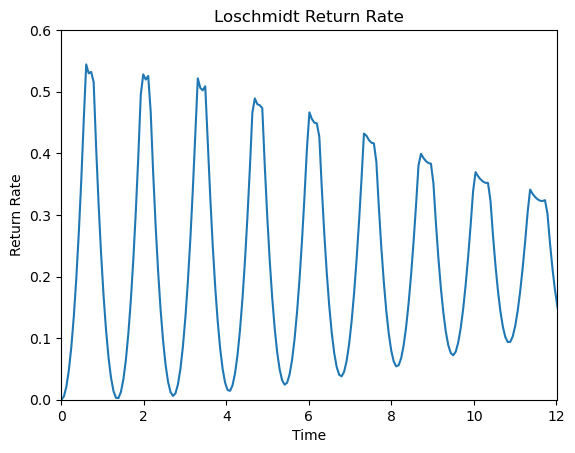

In [25]:
"""Plotting the return rate against time"""

plt.plot(t_array , limit_rate_using_quad)
plt.xlim(0 , t_array[200])
plt.ylim(0,0.6)
plt.title("Loschmidt Return Rate")
plt.xlabel("Time")
plt.ylabel("Return Rate")
#plt.savefig("LE_return_rate.png")

In [26]:
"""Creating a 2D array for Gk for all values of t and k. This takes ~6 minutes to run!"""
Gk_array = np.zeros((len(t_array) , len(k_array)) , dtype = complex)

for t_index in tqdm(range(len(Gk_array))):
    for k_index in range(len(Gk_array[t_index])):
        Gk_array[t_index , k_index] = Gk_v2(t_array[t_index] , k_array[k_index] , initial_params , final_params)[0]



  0%|          | 0/500 [00:00<?, ?it/s]

In [27]:
#np.savetxt("Gk_var_data.txt" , Gk_array)

In [28]:
#Gk_array = np.loadtxt("Gk_var_data.txt" , dtype = complex)

In [29]:
"""Defining the LE return rate using the Gk array rather than using scipy quad as above. We get the same asnwer so this doesn't matter"""

limit_rate = -(1/(2*pi))*np.trapz(np.log(np.abs(Gk_array)) , k_array , axis=1)

In [30]:
#np.savetxt("limit_rate_var_data.txt" , limit_rate)

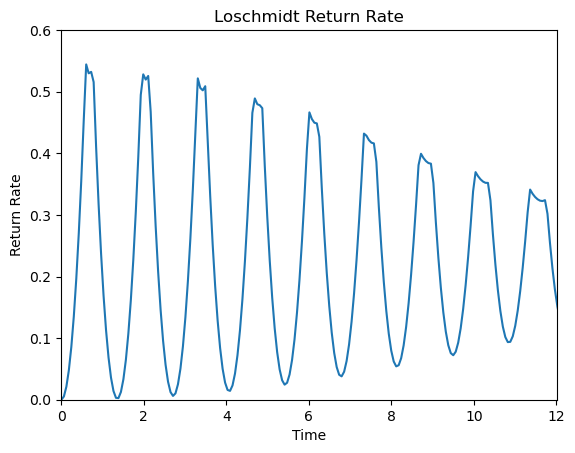

In [31]:
"""Plotting the LE return rate obtained from the Gk array. It is the same as the return rate obtained from scipy quad"""

plt.plot(t_array , limit_rate)
plt.xlim(0 , t_array[200])
plt.ylim(0,0.6)
plt.title("Loschmidt Return Rate")
plt.xlabel("Time")
plt.ylabel("Return Rate")
plt.savefig("LE_return_rate.png")

In [32]:
"""Now defining the PGP. For that we need to define the dynamical phase first"""

def dphi_dyn(t , k , initial_params , final_params):

    vi = initial_params[0]
    wi = initial_params[1]

    vf = final_params[0]
    wf = final_params[1]
    gamma = final_params[2]

    left_eigenbra_initial_plus = biorth_VU(k , initial_params)[1][0]
    left_eigenbra_initial_minus = biorth_VU(k , initial_params)[1][1]

    right_eigenket_initial_plus = biorth_VU(k , initial_params)[2][:,0]
    right_eigenket_initial_minus = biorth_VU(k , initial_params)[2][:,1]

    
    kappa_f_pm , Vf , Uf = biorth_VU(k , final_params)
    Hf = Hk(k , final_params)

    kappa_f_pm_Hdagger , Uf_Hdagger , Vf_Hdagger = biorth_VU(k , final_params , dagger = True)


    #left_eigenbra_initial_plus_in_Hf_eigenbasis = left_eigenbra_initial_plus@Uf
    left_eigenbra_initial_minus_in_Hf_eigenbasis = left_eigenbra_initial_minus@Uf

    #right_eigenket_initial_plus_in_Hf_eigenbasis = Vf@right_eigenket_initial_plus
    right_eigenket_initial_minus_in_Hf_eigenbasis = Vf@right_eigenket_initial_minus


    Hf_diagonal = np.zeros((2,2) , dtype = complex)
    Hf_diagonal[0,0] = kappa_f_pm[0]
    Hf_diagonal[1,1] = kappa_f_pm[1]

    exp_Hf_diagonal = np.zeros((2,2) , dtype = complex)
    exp_Hf_diagonal[0,0] = np.exp(-I*t*kappa_f_pm[0])
    exp_Hf_diagonal[1,1] = np.exp(-I*t*kappa_f_pm[1])

    HfDagger = np.matrix.getH(Hf)
    HfDagger_in_Hf_eigenbasis = Vf @ HfDagger @ Uf
    exp_HfDagger_in_Hf_eigenbasis = scilinalg.expm(I*t*HfDagger_in_Hf_eigenbasis)

    norm_term = np.sqrt( left_eigenbra_initial_minus_in_Hf_eigenbasis @ exp_HfDagger_in_Hf_eigenbasis @ exp_Hf_diagonal @ right_eigenket_initial_minus_in_Hf_eigenbasis )

    right_term = ( exp_Hf_diagonal @ right_eigenket_initial_minus_in_Hf_eigenbasis ) / norm_term

    left_term = ( left_eigenbra_initial_minus_in_Hf_eigenbasis @ exp_HfDagger_in_Hf_eigenbasis )/ norm_term

    dphi_dyn = -np.real(left_term @ Hf_diagonal @ right_term)

    # norm_term_right_in_Hf_eigenbasis = exp_Hf @ right_eigenket_initial_minus_in_Hf_eigenbasis
    # norm_term_left_in_HfDagger_eigenbasis = left_eigenbra_initial_minus_in_Hfdagger_eigenbasis @ exp_HfDagger

    return dphi_dyn


In [33]:
quad

<function scipy.integrate._quadpack_py.quad(func, a, b, args=(), full_output=0, epsabs=1.49e-08, epsrel=1.49e-08, limit=50, points=None, weight=None, wvar=None, wopts=None, maxp1=50, limlst=50, complex_func=False)>

In [34]:
dphi_dyn_array = np.zeros((len(t_array) , len(k_array)) , dtype = complex)

for t_index in tqdm(range(len(dphi_dyn_array))):
    for k_index in range(len(dphi_dyn_array[t_index])):
        dphi_dyn_array[t_index , k_index] = dphi_dyn(t_array[t_index] , k_array[k_index] , initial_params , final_params)



  0%|          | 0/500 [00:00<?, ?it/s]

In [35]:
#dphi_dyn_array = np.loadtxt("dphi_dyn_data.txt" , dtype = complex)

In [36]:
#np.savetxt("dphi_dyn_data.txt" , dphi_dyn_array)

In [37]:
"""Defining the dynamical phase from dphi (by performing the time integral) here"""
phi_dyn_array = np.zeros((len(t_array) , len(k_array)) , dtype = complex)

for i in tqdm(range(len(t_array))):
    phi_dyn_array[i] = np.trapz(dphi_dyn_array[:i] , t_array[:i] , axis = 0)



  0%|          | 0/500 [00:00<?, ?it/s]

In [41]:
"""Defining the Pancharatnam Geometric Phase (PGP) and dnu, where nu = DTOP"""

PGP = np.zeros((len(t_array) , len(k_array)) , dtype = complex)

for i in tqdm(range(len(t_array))):  # i know i don't need to loop this, PGP = angle(Gk) - phi_dyn will suffice, will change later
    for k_val in range(len(k_array)):
        if (np.imag(phi_dyn_array[i,k_val]) + np.imag(-I*np.log(Gk_array[i,k_val] / np.abs(Gk_array[i,k_val]))))>1e-10:
            break
        PGP[i,k_val] = make_periodic(   make_periodic(np.real(-I*np.log(   Gk_array[i,k_val] / np.abs(Gk_array[i,k_val])  ) ))   - make_periodic(  np.real(phi_dyn_array[i,k_val])  )   )


  0%|          | 0/500 [00:00<?, ?it/s]

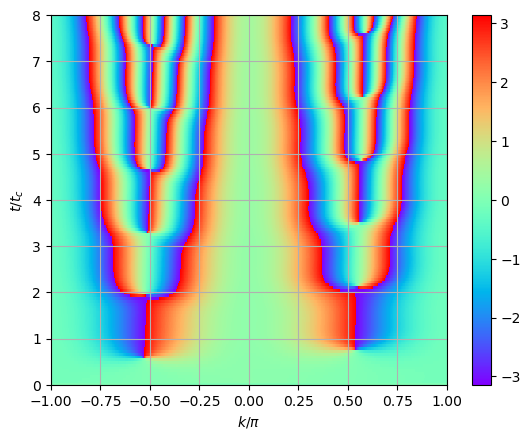

In [42]:
#%matplotlib qt
plt.pcolormesh(k_array/pi , t_array , np.real(PGP) , cmap = 'rainbow')
plt.colorbar()
#plt.grid()
plt.xlabel(r'$k/\pi$')
plt.ylabel(r'$t/t_c$')
# plt.clim(-8 , 0)
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.yscale('log')
# #plt.xlim(10,95)
# plt.ylim(10,4000)
# plt.xlim(0,1)
# plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid()
#plt.xlim(0,1)
plt.ylim(0,8)
plt.show()



c:\Users\Lenovo\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


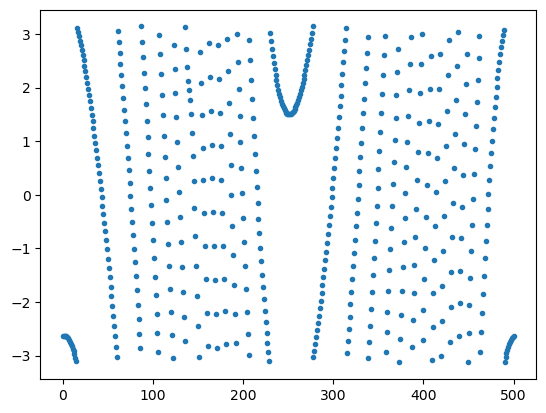

In [40]:
plt.plot(PGP[300] , ".")